In [1]:
import wandb
api = wandb.Api()
project = 'iit'
group = 'eval'
runs = api.runs(f'{project}', filters={"group": group, "state": "finished"})
print(runs)

<Runs cybershiptrooper/iit>


In [2]:
from tqdm import tqdm

files_to_download = ['results.csv', 'metric_collection.log', 'train_args.log', 'results_kl_div.csv']
print("Downloading files for runs")
for r in runs:
    print(r.name)
    # download all the run files in the run directory
    for file in tqdm(r.files()):
        if any([file.name.endswith(ftd) for ftd in files_to_download]):
            file.download(replace=True)

node_effect_8_weight_tracr_accuracy


100%|██████████| 12/12 [00:00<00:00, 16.87it/s]


node_effect_8_weight_510_accuracy


100%|██████████| 12/12 [00:00<00:00, 15.33it/s]


node_effect_24_weight_tracr_kl_div


100%|██████████| 12/12 [00:01<00:00, 10.35it/s]


node_effect_24_weight_510_kl_div


100%|██████████| 12/12 [00:01<00:00,  9.83it/s]


node_effect_8_weight_tracr_kl_div


100%|██████████| 12/12 [00:01<00:00,  9.89it/s]


node_effect_8_weight_510_kl_div


100%|██████████| 12/12 [00:01<00:00,  9.56it/s]


node_effect_24_weight_tracr_accuracy


100%|██████████| 12/12 [00:00<00:00, 15.37it/s]


node_effect_24_weight_510_accuracy


100%|██████████| 12/12 [00:00<00:00, 13.39it/s]


node_effect_4_weight_tracr


100%|██████████| 12/12 [00:01<00:00,  9.72it/s]


node_effect_21_weight_tracr_kl_div


100%|██████████| 12/12 [00:01<00:00, 11.37it/s]


node_effect_21_weight_tracr_accuracy


100%|██████████| 12/12 [00:00<00:00, 16.17it/s]


node_effect_4_weight_510


100%|██████████| 12/12 [00:01<00:00,  9.77it/s]


node_effect_21_weight_510_kl_div


100%|██████████| 13/13 [00:01<00:00, 10.29it/s]


node_effect_21_weight_510_accuracy


100%|██████████| 12/12 [00:00<00:00, 12.42it/s]


node_effect_3_weight_tracr


100%|██████████| 14/14 [00:01<00:00, 11.71it/s]


node_effect_3_weight_510


100%|██████████| 16/16 [00:01<00:00, 13.99it/s]


In [3]:
import dataframe_image as dfi
import os

def make_image(results_dict, folder, run, kl_div=False):
    # remove unnamed columns from results
    images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
    if make_image and not os.path.exists(images_path):
        dfi.export(results_dict[run], images_path)

In [4]:
import pandas as pd

def walk_wandb_dir_and_get_results(weight: float = 510, make_image: bool = True):
    def drop_bad_columns_and_make_image(df, folder, kl_div=False):
        df.drop(columns=[c for c in df.columns if 'Unnamed' in c], inplace=True)
        if make_image:
            images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
            dfi.export(df, images_path)
        return df
    
    results = {}
    results_kl_div = {}
    for run in os.listdir('./results/ll_models/'):
        folder = os.path.join('./results/ll_models/', run, f'results_{weight}')
        result = os.path.join(folder, 'results.csv')
        result_kl_div = os.path.join(folder, 'results_kl_div.csv')
        if os.path.exists(result):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result), folder, kl_div=False)
        if os.path.exists(result_kl_div):
            results_kl_div[run] = drop_bad_columns_and_make_image(pd.read_csv(result_kl_div), folder, kl_div=True)
    return results

In [5]:
results = walk_wandb_dir_and_get_results()

In [6]:
import matplotlib.pyplot as plt


def plot_results(
    results,
    key="resample_ablate_effect",
    normalize_by_runs=True,
    figsize=(10, 5),
):
    if normalize_by_runs:
        for _, df in results.items():
            # normalize the values of the key column by the maximum value in the column
            df[key] = df[key] / df[key].max()

    # combine dataframes for each run, and add a column for the run name
    df_combined = pd.concat([df.assign(run=run) for run, df in results.items()])

    # box plot df['resample_ablate_effect'] where df['status] for each df['run'] in the same line
    in_circuit_list = [
        run_df[1].groupby("status").get_group("in_circuit")
        for run_df in df_combined.groupby("run")
    ]
    not_in_circuit_list = [
        run_df[1].groupby("status").get_group("not_in_circuit")
        for run_df in df_combined.groupby("run")
    ]

    columns = results.keys()
    plt.figure(figsize=figsize)
    plt.title(f"{key} for different runs")
    c = "darkcyan"
    plt.boxplot(
        [df[key] for df in in_circuit_list],
        positions=range(0, len(columns) * 2, 2),
        patch_artist=True,
        showfliers=False,
        boxprops=dict(facecolor=c, color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color=c),
    )

    c = "orangered"
    plt.boxplot(
        [df[key] for df in not_in_circuit_list],
        positions=range(0, len(columns) * 2, 2),
        patch_artist=True,
        showfliers=False,
        boxprops=dict(facecolor=c, color=c),
        capprops=dict(color=c),
        whiskerprops=dict(color=c),
        flierprops=dict(color=c, markeredgecolor=c),
        medianprops=dict(color=c),
    )

    plt.xticks(
        range(0, len(columns) * 2, 2),
        [in_circuit_list[i].iloc[0]["run"] for i in range(len(columns))],
    )

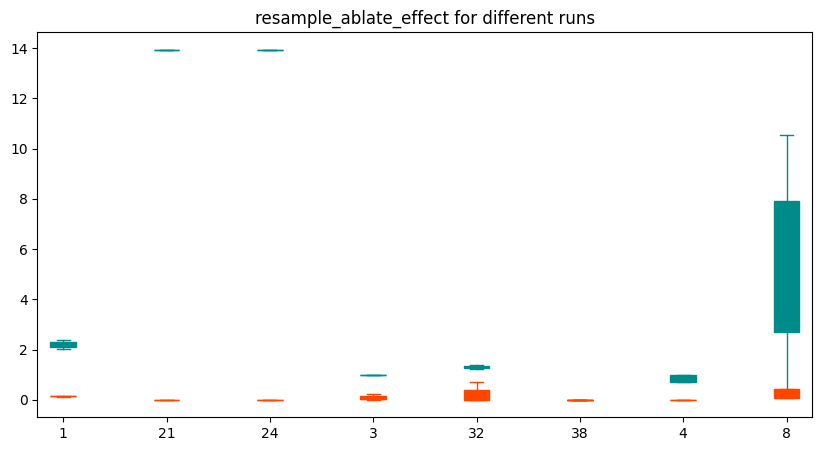

In [8]:
plot_results(results, 
             key = "resample_ablate_effect",
             normalize_by_runs=False)